<h1>Imports<h1>

In [1]:
#setting rood directory into ../NeuralPowerDisaggregation
import os
os.chdir("..")
print(os.getcwd())

/work/lurny/files/Thesis


In [2]:
config = {
    'gdt': {
        'depth': 5,
                
        'learning_rate_index': 0.05,
        'learning_rate_values': 0.01,
        'learning_rate_leaf': 0.005,
        
        'dropout': 0.2, #0.2 oder 0.5
        
        
        'initializer_values': 'GlorotUniform', 
        'initializer_index': 'GlorotUniform', 
        'initializer_leaf': 'GlorotUniform', 
        
        'optimizer': 'adam', 
        
        'batch_size': 120,
        'epochs': 1,
        
        'restarts': 10,
        'restart_type': 'loss', #'loss', 'metric'
        
        'early_stopping_epochs': 200,
        'early_stopping_type': 'loss', #'loss', 'metric'
        'early_stopping_epsilon': 0.0,
    },
    
    'preprocessing': {
        'balance_threshold': 0,#.25, #if minclass fraction less than threshold/num_classes | #0=no rebalance, 1=rebalance all
        'normalization_technique': 'mean', #'min-max'
    },

    'computation': {
        'random_seed': 42,
        'trials': 10, # fixed to 1 for HPO
        
        'use_best_hpo_result': True,
        'force_depth': False,
        
        'use_gpu': True,
        'gpu_numbers': '1',#'1',
        'n_jobs': 10, #vorher 20
        'verbosity': 0,
        
        
        'hpo': None,#'binary', #'binary', 'multi', 'regression'
        'search_iterations': 300,
        'cv_num': 3,     
        
        'metrics_class': ['f1', 'roc_auc', 'accuracy'],
        
        'metrics_reg': ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_absolute_error', 'neg_mean_squared_error'],
        
        'eval_metric_class': ['f1', 'roc_auc'], #f1 accuracy
        'eval_metric_reg': 'r2', #r2 mae        
        
        'max_total_samples': 20000,
        'chunk_size': 200,#default 200
    },
    
    'benchmarks': {
        #'sklearn': True,
        #'GeneticTree': True,        
    }
}

In [3]:
import numpy as np
np.set_printoptions(suppress=True)

import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, ParameterGrid, ParameterSampler, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
#from pydl85 import DL85Classifier

from livelossplot import PlotLosses

import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from IPython.display import Image
from IPython.display import display, clear_output

import pandas as pd

if config['computation']['use_gpu']:
    os.environ['CUDA_VISIBLE_DEVICES'] = str(config['computation']['gpu_numbers'])
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
    os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/usr/local/cuda-11.6"
    os.environ['TF_XLA_FLAGS'] = "--tf_xla_enable_xla_devices --tf_xla_auto_jit=2"    
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'false' 
#os.environ['TF_XLA_FLAGS'] = "--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit" 


import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["PYTHONWARNINGS"] = "ignore"
import logging

import tensorflow as tf
import tensorflow_addons as tfa

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

np.seterr(all="ignore")

from keras import backend as K
from keras.utils.generic_utils import get_custom_objects


import seaborn as sns
sns.set_style("darkgrid")

import time
import random

from utilities.utilities_GDT import *
from utilities.GDT_for_streams import *

from joblib import Parallel, delayed

from itertools import product
from collections.abc import Iterable

from copy import deepcopy
from pathlib import Path
import pickle
import dill

tf.random.set_seed(config['computation']['random_seed'])
np.random.seed(config['computation']['random_seed'])
random.seed(config['computation']['random_seed'])

from datetime import datetime
timestr = datetime.utcnow().strftime('%Y-%m-%d--%H-%M-%S%f')
print(timestr)
os.makedirs(os.path.dirname("./evaluation_results/latex_tables/" + timestr +"/"), exist_ok=True)

filepath = './evaluation_results/depth' + str(config['gdt']['depth']) + '/' + timestr + '/'
Path(filepath).mkdir(parents=True, exist_ok=True)    


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

2023-01-04--07-59-53600420


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  1
Num XLA-GPUs Available:  1


In [5]:
import math
def split_df_chunks(data_df,chunk_size):
    total_length     = len(data_df)
    normal_chunk_num = math.floor(total_length/chunk_size)
    chunks = []
    for i in range(normal_chunk_num):
        chunk = data_df[(i*chunk_size):((i+1)*chunk_size)]
        chunks.append(chunk)

    return chunks

# Evaluation of agr_a dataset

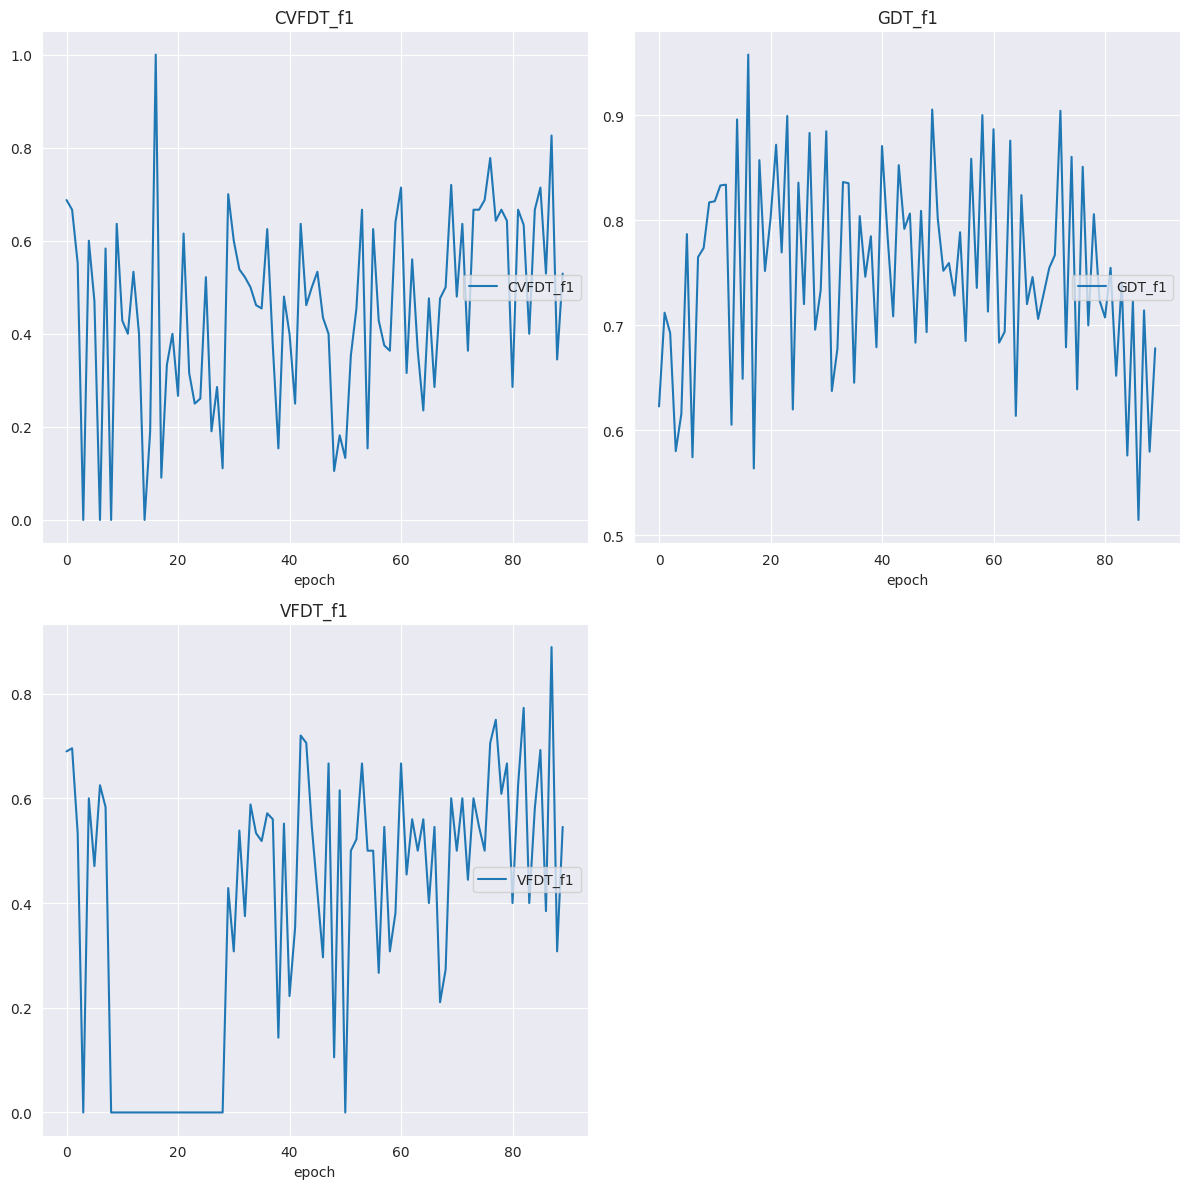

CVFDT_f1
	CVFDT_f1         	 (min:    0.000, max:    1.000, cur:    0.529)
GDT_f1
	GDT_f1           	 (min:    0.514, max:    0.958, cur:    0.678)
VFDT_f1
	VFDT_f1          	 (min:    0.000, max:    0.889, cur:    0.545)


In [10]:
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.trees import HoeffdingAdaptiveTreeClassifier
from sklearn.metrics import f1_score
from livelossplot import PlotLosses
import time


VFDT_classifier = HoeffdingTreeClassifier()
CVFDT_classifier = HoeffdingAdaptiveTreeClassifier(split_confidence = 0.001)

config_training, metrics = prepare_training_for_streams(identifier = 'BIN:NOAA_Weather', config = config)
#load Dataset
X_data, y_data, nominal_features, ordinal_features = load_dataset_for_streams(identifier = 'BIN:NOAA_Weather', 
                                                                              max_total_samples = config['computation']['max_total_samples'])


X_data_stream = split_df_chunks(X_data, config['computation']['chunk_size'])
y_data_stream = split_df_chunks(y_data, config['computation']['chunk_size'])


model_dict = {}
scores_dict = {}
normalizer_list = []
scores_GDT_f1 = np.array([])
scores_VFDT_f1 = np.array([])
scores_CVFDT_f1 = np.array([])

benchmark_dict_HT = {'y_pred':[],
                 'y_valid':[]}
benchmark_dict_GDT = {'y_pred':[],
                 'y_valid':[]}

verbosity = 1

model_dict['GDT'] = GDT(number_of_variables = len(X_data.columns),
            number_of_classes = len(np.unique(y_data)),#dataset_dict['number_of_classes'],

            objective = config_training['gdt']['objective'],

            depth = config_training['gdt']['depth'],

            learning_rate_index = config_training['gdt']['learning_rate_index'],
            learning_rate_values = config_training['gdt']['learning_rate_values'],
            learning_rate_leaf = config_training['gdt']['learning_rate_leaf'],

            optimizer = config_training['gdt']['optimizer'],

            loss = 'crossentropy',

            initializer_values = config_training['gdt']['initializer_values'],
            initializer_index = config_training['gdt']['initializer_index'],
            initializer_leaf = config_training['gdt']['initializer_leaf'],        

            random_seed = config_training['computation']['random_seed'],
            verbosity = verbosity)  

plotlosses_benchmark = PlotLosses()

preprocessing_time = 0
GDT_time = 0
VFDT_time = 0
training_time = 0
CVFDT_time = 0




#Start Stream

for i in range(len(X_data_stream)):
    t0 = time.time()
    ((X_train, y_train),
     (X_valid, y_valid),
     (X_test, y_test),
     normalizer_list) = preprocess_data(X_data_stream[i], 
                                       y_data_stream[i],
                                       nominal_features,
                                       ordinal_features,
                                       config_training,
                                       normalizer_list,
                                       random_seed= 42,#random_seed,
                                       verbosity=1)#verbosity)  
    dataset_dict = {
           'X_train': X_train,
           'y_train': y_train,
           'X_valid': X_valid,
           'y_valid': y_valid,
           'X_test': X_test,
           'y_test': y_test,
           'normalizer_list': normalizer_list
           }
    t1 = time.time()
    preprocessing_time = preprocessing_time + t1-t0

    t0 = time.time()
    
    history = model_dict['GDT'].partial_fit(dataset_dict['X_train'],
              dataset_dict['y_train'],

              batch_size=config_training['gdt']['batch_size'], 
              epochs=config_training['gdt']['epochs'], 

              restarts = 0,#config_test['gdt']['restarts'], 
              #restart_type=config_test['gdt']['restart_type'], 

              #early_stopping_epochs=config_training['gdt']['early_stopping_epochs'], 
              #early_stopping_type=config_test['gdt']['early_stopping_type'],

              valid_data=(dataset_dict['X_valid'],dataset_dict['y_valid']))
    
    t1 = time.time()
    GDT_time = GDT_time + t1-t0
    training_time = training_time + t1-t0
    
    ###EVALUATION
    y_test_data =dataset_dict['y_test'].tolist()
    
    temp_X_train =dataset_dict['X_train'].values
    temp_y_train =dataset_dict['y_train'].values
    temp_X_test = dataset_dict['X_test'].values
    
    t0 = time.time()
    #GDT
    metric = "f1"
    y_test_data = dataset_dict['y_test']
    y_pred_GDT = model_dict['GDT'].predict(enforce_numpy(temp_X_test))
    y_pred_GDT = np.nan_to_num(y_pred_GDT)
    y_pred_GDT = np.round(y_pred_GDT)
    GDT_f1 = sklearn.metrics.get_scorer(metric)._score_func(y_pred_GDT, y_test, average='weighted')
       
    t1 = time.time()
    GDT_time = GDT_time + t1-t0
    

    #VFDT
    t0 = time.time()
    y_pred_VFDT = []
    for i in range(0, len(dataset_dict['X_train'])):
        VFDT_classifier.partial_fit(np.array([temp_X_train[i]], np.float64), np.array([temp_y_train[i]], np.float64))
    for i in range(0, len(dataset_dict['X_test'])):
        y_pred_VFDT.append(VFDT_classifier.predict(np.array([temp_X_test[i]], np.float64))[0])  
    VFDT_f1 = f1_score(y_test_data, y_pred_VFDT)
    t1 = time.time()
    VFDT_time = VFDT_time + t1-t0
    
    #CVFDT
    t0 = time.time()
    y_pred_CVFDT = []
    for i in range(0, len(dataset_dict['X_train'])):
        CVFDT_classifier.partial_fit(np.array([temp_X_train[i]], np.float64), np.array([temp_y_train[i]], np.float64))
    for i in range(0, len(dataset_dict['X_test'])):
        y_pred_CVFDT.append(CVFDT_classifier.predict(np.array([temp_X_test[i]], np.float64))[0])  
    CVFDT_f1 = f1_score(y_test_data, y_pred_CVFDT)
    t1 = time.time()
    CVFDT_time = VFDT_time + t1-t0
    
    
    plotlosses_benchmark.update({'GDT_f1': GDT_f1,'VFDT_f1': VFDT_f1, 'CVFDT_f1':CVFDT_f1})
    plotlosses_benchmark.send() 
    
    
    scores_GDT_f1 = np.append(scores_GDT_f1, GDT_f1)
    scores_VFDT_f1 = np.append(scores_VFDT_f1, VFDT_f1)
    scores_CVFDT_f1 = np.append(scores_CVFDT_f1, CVFDT_f1)
    
    
     

    #scores_dict['GDT'] = calculate_scores(model_dict = model_dict, 
     #                              dataset_dict = dataset_dict, 
      #                             scores_dict = prepare_score_dict(config=config_training), 
       #                            metrics = metrics)            

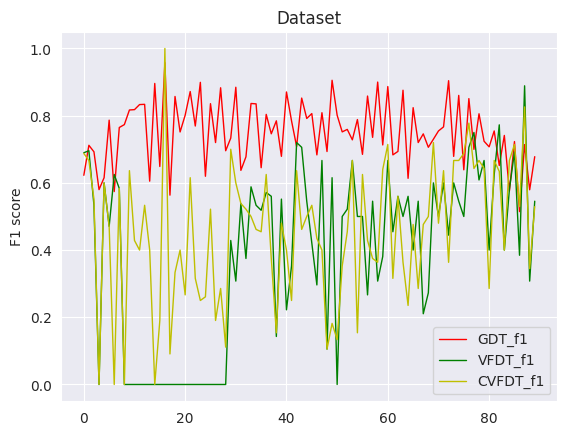

median GDT F1: 0.748819307925273
median VFDT F1: 0.4852941176470588
median CVFDT F1: 0.4852941176470588

preprocessing_time: 1.002152919769287
training_time: 147.14319396018982
GDT_time: 148.50848245620728
VFDT_time: 1.4004878997802734
CVFDT_time: 1.4956388473510742


In [12]:
#Plot results
X = np.arange(0, len(scores_GDT_f1), 1)
  
# Assign variables to the y axis part of the curve
  
# Plotting both the curves simultaneously
plt.plot(X, scores_GDT_f1, color='r', label='GDT_f1', linewidth=1)
plt.plot(X, scores_VFDT_f1, color='g', label='VFDT_f1', linewidth=1)
plt.plot(X, scores_CVFDT_f1, color='y', label='CVFDT_f1', linewidth=1)
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("")
plt.ylabel("F1 score")
plt.title("Dataset")
plt.legend()
plt.show()

print("median GDT F1: " + str(np.median(scores_GDT_f1)))
print("median VFDT F1: " + str(np.median(scores_VFDT_f1)))
print("median CVFDT F1: " + str(np.median(scores_VFDT_f1)))


print("")
print("preprocessing_time: " + str(preprocessing_time))
print("training_time: "+ str(training_time))
print("GDT_time: " + str(GDT_time))
print("VFDT_time: " + str(VFDT_time))
print("CVFDT_time: " + str(CVFDT_time))